Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Found 8000 files belonging to 8 classes.
Using 1600 files for validation.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 818s 13s/step - accuracy: 0.7249 - loss: 0.7410 - val_accuracy: 0.2512 - val_loss: 3.6600 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9018 - loss: 0.2653 - val_accuracy: 0.5841 - val_loss: 2.5765 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9366 - loss: 0.1623 - val_accuracy: 0.6442 - val_loss: 2.8795 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9523 - loss: 0.1286 - val_accuracy: 0.8594 - val_loss: 0.5431 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9543 - loss: 0.1203 - val_accuracy: 0.7428 - val_loss: 1.1088 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step -

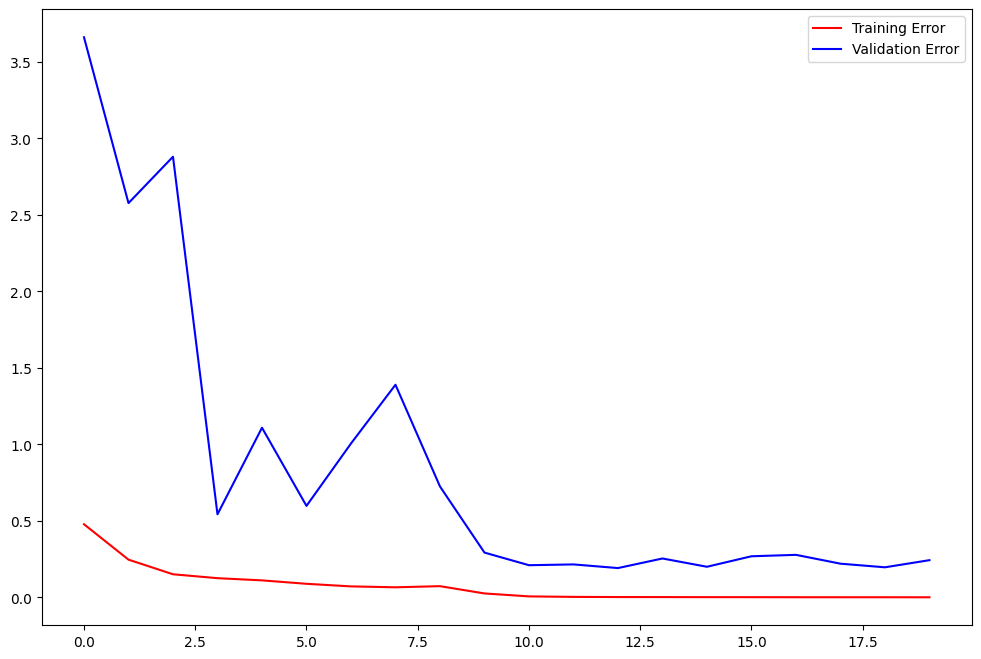

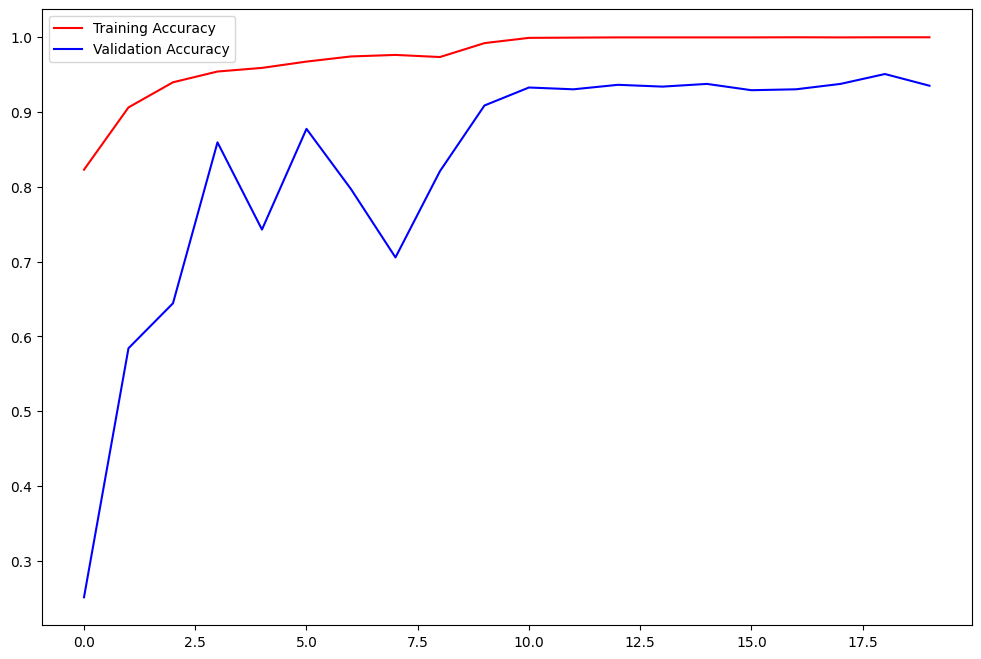

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Accuracy: 0.92
Micro F1 Score: 0.92
Macro F1 Score: 0.92
Weighted F1 Score: 0.92

Classification Report:
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.87      0.93      0.90        84
dyed-resection-margins       0.94      0.88      0.91       101
           esophagitis       0.79      0.81      0.80        90
          normal-cecum       0.98      1.00      0.99        98
        normal-pylorus       0.96      1.00      0.98        96
         normal-z-line       0.84      0.83      0.84       107
                polyps       0.99      0.97      0.98        87
    ulcerative-colitis       1.00      0.95      0.98       105

              accuracy                           0.92       768
             macro a

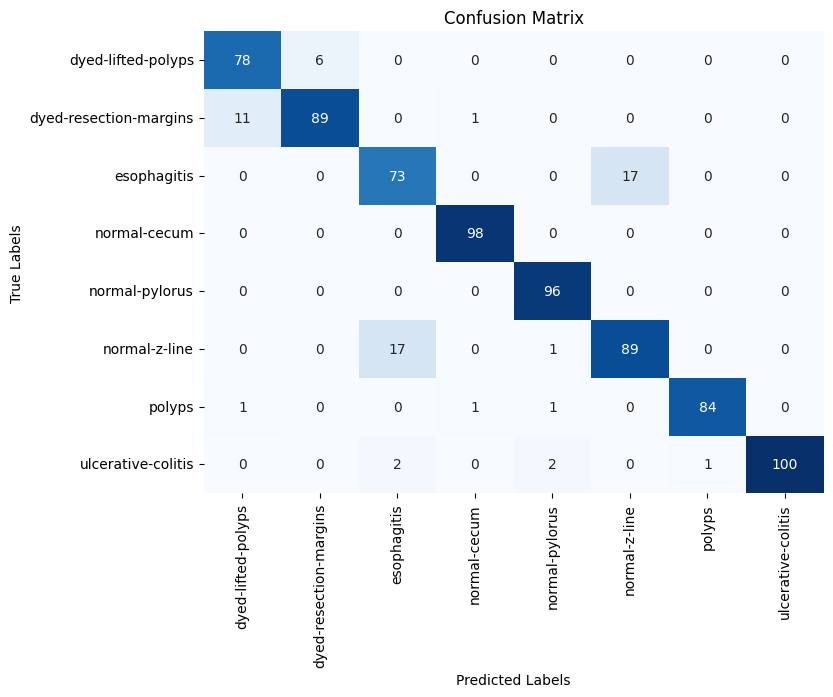

Final Training Accuracy: 1.00
Final Validation Accuracy: 0.94


In [1]:
import tensorflow as tf
tf.config.list_physical_devices(
    device_type=None
)
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Dataset configuration
dataset_path = "/content/drive/MyDrive/kvasir-dataset-v2/kvasir-dataset-v2"
image_size = (299, 299)
batch_size = 128

train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Model definition
model = Sequential()
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base_model.layers:
    layer.trainable = True
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.004),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=20)

model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[reduce_lr, early_stop])
model.save("final.h5")

# Plotting training and validation accuracy
history = model.history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12,8))
plt.plot(loss, color='r', label='Training Error')
plt.plot(val_loss, color='b', label='Validation Error')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(accuracy, color='r', label='Training Accuracy')
plt.plot(val_accuracy, color='b', label='Validation Accuracy')
plt.legend()
plt.show()

# Model evaluation and F1 score calculation
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Calculate F1 Scores
f1_micro = f1_score(true_labels, predicted_labels, average='micro')
f1_macro = f1_score(true_labels, predicted_labels, average='macro')
f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Micro F1 Score: {f1_micro:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Retrieve the final training and validation accuracy (from the last epoch)
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_training_accuracy:.2f}")
print(f"Final Validation Accuracy: {final_validation_accuracy:.2f}")
